In [1]:
import os, sys

sys.path.append('/Users/clancy/repos/approximate_mle/python')
sys.path.append('/Users/clancy/repos/approximate_mle/')


import numpy as np
import pandas as pd
from  loglikelihood import loglikelihood
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
# total least squares for call for

def TLS(A,b):
    m, n = A.shape
    C = np.hstack((A,b.reshape(m,1)))
    
    # unlike matlab, numpy returns V.T
    _, _, Vt = np.linalg.svd(C)

    # take last row (smallest singular vector)
    v = Vt[-1,:]
    x_tls = -(1/v[-1])*v[:-1]

    return x_tls

In [3]:
df = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')

myidx = df['MSZoning'] == 'RL'
df = df.loc[myidx,:]

myidx = df.LotArea < df.LotArea.quantile(0.99) 
df = df.loc[myidx,:]
myidx = df.GrLivArea < df.GrLivArea.quantile(0.99) 
df = df.loc[myidx,:]
myidx = df.SalePrice < df.SalePrice.quantile(0.99)
df = df.loc[myidx,:]


In [4]:
tb = df.loc[:, ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'GrLivArea', 'SalePrice']]


myidx =  df.LotArea < df.LotArea.quantile(0.99) 


In [5]:
tb.dropna(axis=0,how='any', inplace=True)
tb

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,GrLivArea,SalePrice
0,65.0,8450,7,5,2003,1710,208500
1,80.0,9600,6,8,1976,1262,181500
2,68.0,11250,7,5,2001,1786,223500
3,60.0,9550,7,5,1915,1717,140000
4,84.0,14260,8,5,2000,2198,250000
...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,1647,175000
1456,85.0,13175,6,6,1978,2073,210000
1457,66.0,9042,7,9,1941,2340,266500
1458,68.0,9717,5,6,1950,1078,142125


In [6]:
TB = np.asarray(tb)

In [7]:
tb

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,GrLivArea,SalePrice
0,65.0,8450,7,5,2003,1710,208500
1,80.0,9600,6,8,1976,1262,181500
2,68.0,11250,7,5,2001,1786,223500
3,60.0,9550,7,5,1915,1717,140000
4,84.0,14260,8,5,2000,2198,250000
...,...,...,...,...,...,...,...
1455,62.0,7917,6,5,1999,1647,175000
1456,85.0,13175,6,6,1978,2073,210000
1457,66.0,9042,7,9,1941,2340,266500
1458,68.0,9717,5,6,1950,1078,142125


We have selected a subset of data that we want to use to fit a model with. These fields are as follows: LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, GrLivArea, and SalePrice. 

Drawing special attention to quality, condition, and year built, we note that the reported values are necessarily subjective. Why you might ask, this is because we are not given a date which the property was completed. As such, we know that the true data was taken somewhere from January to December of the listed year. Hence, the true year built data should be the listed year plus a number drawn from Uniform(0,1), i.e.,for a year of 2010, the true completion date is year $\in [2010, 2011)$.

For overall quality and condition, this is subjective in nature and there will be some uncertainty. This is the target setup for our method. We don't need to specify true values, we just allow values to be taken over and uncertainty set.

0. LotFrontage: Restrict to tens value (uncertainty is Uniform(-5, 5)) 
1. LotArea: Restrict to hundreds (uncertainty is Uniform(-50, 50)) 
2. OverallQual: No change...our model allows for this uncertainty (uncertainty is Uniform(-0.5, 0.5)) 
3. OverallCond: No change...our model allows for this uncertainty (uncertainty is Uniform(-0.5, 0.5)) 
4. YearBuilt: Add 0.5 to all entries to make it middle of range (uncertainty is Uniform(-0.5, 0.5) not Uniform(0, 1))  
5. GrLivArea: Restrict to hundreds (uncertainty is Uniform(-50, 50)) 
6. SalePrice: Response variable. Determine the variance from the model values and use that for $\sigma^2$


There is no such thing as the true matrix at this point, there is just the observed matrix which we suppose is subject to noise. A few columns are in themselves uncertain, several others are not. 


In [8]:
A = TB[:,0:6]
b = TB[:,-1]
b = b - np.mean(b)
Aobs = TB[:,0:6]
Aobs[:,0] = np.round(Aobs[:,0], -1)
Aobs[:,1] = np.round(Aobs[:,1], -2)
Aobs[:,4] = Aobs[:,4] + 0.5
Aobs[:,5] = np.round(Aobs[:,5], -2)

Aobs = Aobs - np.mean(Aobs, axis=0)


A = np.hstack((np.ones((b.shape[0],1)),A))
Aobs = np.hstack((np.ones((b.shape[0],1)),Aobs))

Aobs_orig = Aobs

#Aobs = np.delete(Aobs, 4, 1)

dists = ['constant', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'normal']
params = [None, [5], [50], [0.5], [0.5], [1], [50], [950000000]]

#dists = ['constant', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'normal']
#params = [None, [5], [50], [0.5], [1], [50], [900000000]]


In [9]:
print(Aobs.shape)
print(Aobs_orig.shape)

(895, 7)
(895, 7)


In [10]:
ret = np.linalg.lstsq(A, b, rcond=1e-12)
beta = ret[0]

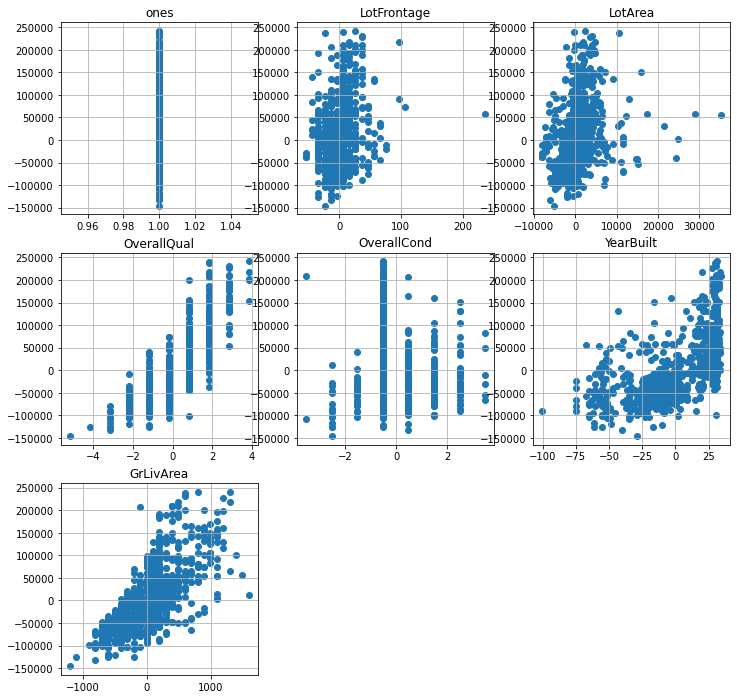

In [11]:
plt.figure(figsize=(12,12))
cols = list(tb.columns)
cols.insert(0,'ones')

temp = np.linalg.lstsq(A, b, rcond=1e-12)
beta = temp[0]



for i, x in enumerate(Aobs.T):
    plt.subplot(3,3,i+1)
    plt.title(cols[i])
    plt.scatter(x,b)
    plt.grid()
    
plt.show()


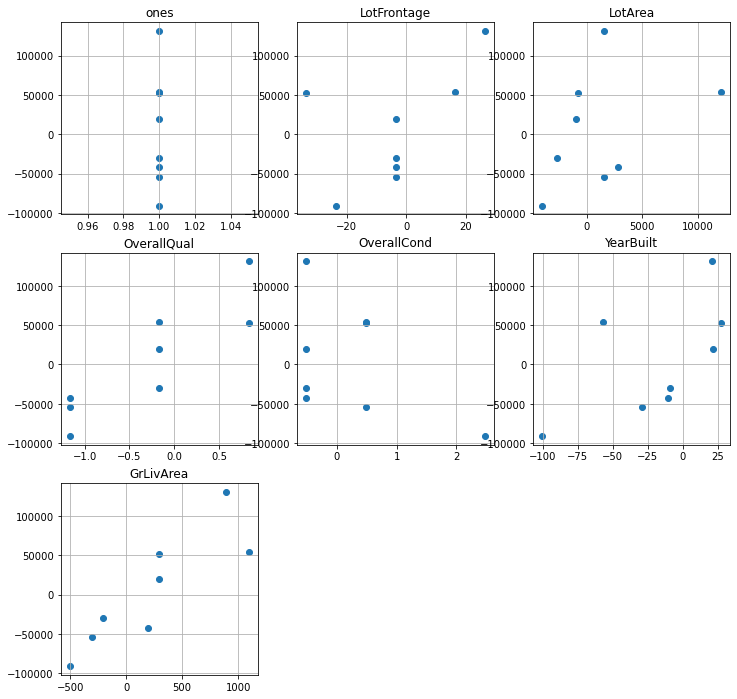

In [12]:
plt.figure(figsize=(12,12))
idx = np.random.permutation(b.shape[0])[0:8]

Atemp = Aobs[idx,:]
btemp = b[idx]



for i, x in enumerate(Aobs[idx,:].T):
    plt.subplot(3,3,i+1)
    plt.title(cols[i])
    plt.scatter(x,b[idx])
    plt.grid()
    
plt.show()

Now for this part of the experiment, we want to try fitting a model using a subset of the data using our regression method and comparing it to total least squares, linear least squares, and the exact MLE using Gaussian noise. 

I outline how this will be done in the following several lines. 

1. Start by taking `Aobs` and `b`
2. Solve OLS problem by using `np.linalg.lstsq(Aobs, b)`
3. Solve TLS problem by using a function call I might still need to write
4. Solve AMLE Problem in the following stages
    - call `llh.func_and_grad` with arguments `H, y, distributions, parameters`
    - `H = Aobs` and `y = b`
    - Distributions are `[constant, uniform, uniform, uniform, uniform, uniform, uniform, normal]` 
    - Parameters are [None, 5, 50, 0.5, 0.5, 1, 50, 30800]

In [13]:
Atemp.shape

(8, 7)

In [14]:
xols = np.linalg.lstsq(Atemp, btemp, rcond=1e-12)[0]

xtls =  TLS(Atemp, btemp)# Write simple code that finds total least square solution


In [15]:




#949060285
#dists = ['uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'normal']
#params = [[5], [50], [0.5], [0.5], [1], [50], [949060285]]



lf = loglikelihood(Atemp, btemp, dists, params)

# define an anonymous function
neg_ll = lambda z: lf.negative_loglikelihood(z)
x0 = np.zeros(xols.shape)
#x0 = np.random.randn(xols.shape[0])
results = optimize.minimize(neg_ll, x0, method='BFGS', jac=True, options={'disp':True, 'ftol':1e-12})
xmle = results.x

/var/folders/93/rs3bwg315nl_l8vgz1bsklv40000gn/T/ipykernel_55233/2917015157.py:13: OptimizeWarning: Unknown solver options: ftol
  results = optimize.minimize(neg_ll, x0, method='BFGS', jac=True, options={'disp':True, 'ftol':1e-12})
/Users/clancy/repos/approximate_mle/python/loglikelihood.py:166: RuntimeWarning: overflow encountered in sinh
  K = h*t*x + np.log(np.sinh(k*t)/(k*t))
/Users/clancy/repos/approximate_mle/python/loglikelihood.py:168: RuntimeWarning: overflow encountered in sinh
  Kpp = 1/t**2 - (k/np.sinh(k*t))**2
/Users/clancy/repos/approximate_mle/python/loglikelihood.py:169: RuntimeWarning: overflow encountered in sinh
  Kppp = -2/t**3 + 2*(k**3)/(np.tanh(k*t)*np.sinh(k*t)**2)
/Users/clancy/repos/approximate_mle/python/loglikelihood.py:172: RuntimeWarning: overflow encountered in sinh
  dKp_dx = h + delta/np.tanh(k*t) - (t*x*(delta**2))/(np.sinh(k*t)**2)
/Users/clancy/repos/approximate_mle/python/loglikelihood.py:173: RuntimeWarning: overflow encountered in sinh
  dKpp_dx

Optimization terminated successfully.
         Current function value: 83.215351
         Iterations: 136
         Function evaluations: 139
         Gradient evaluations: 139


In [16]:
xols

array([ 1.64415899e+04,  1.43581549e+03, -4.47489276e-03,  3.39733143e+04,
        3.23175198e+04,  8.81474727e+02,  5.08186190e+01])

In [17]:
results.x

array([ 5.02766076e+03,  9.39422754e+02, -2.43266816e+00,  2.18308353e+04,
        2.07133837e+04,  6.51144235e+02,  8.60130336e+01])

In [18]:
yols = Aobs@xols
ytls = Aobs@xtls
ymle = Aobs@xmle

print('OLS error', np.linalg.norm(yols -b))
print('TLS error', np.linalg.norm(ytls -b))
print('MLE error', np.linalg.norm(ymle -b))

OLS error 1572215.5798395232
TLS error 1583093.0162281434
MLE error 1195246.5167746167


In [19]:


yols = Atemp@xols
ytls = Atemp@xtls
ymle = Atemp@xmle

print('OLS error', np.linalg.norm(yols -btemp))
print('TLS error', np.linalg.norm(ytls -btemp))
print('MLE error', np.linalg.norm(ymle -btemp))

OLS error 4061.125233828605
TLS error 4077.176881789233
MLE error 18741.399638739476


In [20]:
B = Aobs

B = B - np.mean(B, axis=0)